# Webscraping and analyzing reviews on comics for readcomiconline.to

In [6]:
# GENERAL
import re
import json
import numpy as np
import pandas as pd

# WEBSCRAPING
import requests
import bs4 as bs

# SELENIUM
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait

# NLP
import spacy
from textblob import TextBlob
from collections import Counter
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# GRAPHICS
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 0. Webscrape results, export to dataframe

## 0.0 Functions

In [7]:
def harvest(urls, df=None, outfile="comic_comments/comic_comments.csv"):
    """
    Takes a list of urls of comic series and a df (optional)
    Scrapes and runs NLP for every comic series url in the list.
    Scrapes comments, populates tables and exports CSVs for every issue in the series.
    Returns df of all comics/comments
    """
    # INITIATE DF IF NOT PASSED IN
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print(f"df loaded. df length: {len(df)}")

    # CALLS SCRAPE_SERIES FOR EACH SERIES, UPDATES df
    for series_homepage in urls:
        df = scrape_series(series_homepage=series_homepage, outfile=outfile, df=df)
        
    return df

In [15]:
# SCRAPE COMIC SERIES URL - GET ALL ISSUES URL
def get_issues(series_homepage):
    """
    Takes in a url for a comic series
    Returns a list of every comic's link in the series
    """
    
    # INSTANTATE SELENIUM WEBDRIVER
    driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
#     driver = webdriver.Chrome(executable_path='webdriver/chromedriver')

    # LOAD COMIC SERIES PAGE TO SCRAPE
    driver.get(series_homepage)
    driver.implicitly_wait(15) # Wait to load
    
    driver.implicitly_wait(60) # Extra wait time (for CAPTCHA)
    
    # GET LIST OF issue_urls
    issue_table = driver.find_element_by_class_name("listing")
    all_issues = issue_table.find_elements_by_tag_name("a")
    issue_urls = [issue.get_attribute("href") for issue in all_issues]
    print(f"Get Issues: total issues found: {len(issue_urls)}")
    driver.close() # close webpage
    return(issue_urls)

In [27]:
def scrape_series(series_homepage, outfile="comic_comments/comic_comments.csv", df=None, prev_fails=0):
    """
    Takes in a comic series homepage (e.g. https://readcomiconline.to/Comic/The-Wild-Storm/)
    Can be passed a df with some issues already scraped (df=None)
    Can set the outfile (outfile="comic_comments/comic_comments.csv")
    Saves running df of scraped comments to outfile
    Returns a df populated with comments for all scraped issues for the series
    """
    print(f"Scrape_series initaiated for {series_homepage}")
    fails = 0
    max_fails = 8
    issues_scraped = 0
    
    # INITIATE DF IF NOT PASSED IN
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print(f"df loaded. df length: {len(df)}")

    # GET ALL ISSUE URLS FOR A SERIES
    issue_urls = get_issues(series_homepage)
    print(f"Scrape_series: {len(issue_urls)} issues found for {series_homepage}")
    
    # FOR EVERY ISSUE IN THE SERIES...
    for issue_url in issue_urls:
        if fails >= max_fails: # MAX FAILS CONDITION (CAPTCHA NEEDS TO BE TOLD YOU'RE A HUMAN)
            print("Max fails reached. Breaking")
            break
        else:
            # REMOVE UNNECESSARY PARAMETERS FROM issue_name (IF PRESENT)
            if "?" in issue_url:
                issue_url = issue_url[:issue_url.find('?id')]

            issue_name = issue_url[33:]

            # ... IF THE ISSUE HAS NOT BEEN SCRAPED YET...
            if issue_name not in df['Webpage'].values:
                print(f"Now scraping: {issue_url}")

                # ... RUN ALL WEBSCRAPING FUNCTIONS
                try:
                    soup = get_comment_soup(issue_url)
                    json_data = soup_to_json(soup)
                    df = get_messages(df, issue_name, json_data)
                    df.to_csv(outfile) # SAVE AFTER EVERY SUCCESSFUL ISSUE SCRAPE
                    issues_scraped = issues_scraped + 1
                    print(f"Total issues scraped: {issues_scraped}")
                        
                # IF WEBSCRAPING FAILS
                except:
                    fails = fails + 1
                    print(f"SCRAPING FAILED for {issue_url} - total fails: {fails}")
                    
                    continue
            else:
                print(f"{issue_name} already scraped.")
                
    # IF ANY ISSUE FAILED TO SCRAPE...
    print(f"Scraped {series_homepage} with {fails} fails.")
    if fails > 0 and fails < max_fails:
        if fails != prev_fails: # ...IF FAILS NOT SAME AS BEFORE, RUNS FUNCTION RECURSIVELY
            df = scrape_series(series_homepage=series_homepage, df=df, prev_fails=fails)
        else:
            print(f"TOTAL SCRAPE FAILS: {fails}")
    
    return df

In [28]:
def get_comment_soup(issue_url):
    """
    For a given url, driver, uses Selenium to get the "src" link to the Disqus comments page.
    Returns bs4 soup file for Disqus comments page.
    """
    
    # INSTANTATE SELENIUM WEBDRIVER
    driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
#     driver = webdriver.Chrome(executable_path='webdriver/chromedriver')
    
    driver.implicitly_wait(60) # Wait 1 minute to reduce CAPTCHA issues
    
    driver.get(issue_url)
    driver.implicitly_wait(15) # Wait to load
    
#     frame = driver.find_elements_by_id("disqus_thread")
#     print("Disqus Threads elements:",len(frame))
    
    iframe = driver.find_elements_by_css_selector("[title='Disqus']")

    iframe_url = iframe[1].get_attribute('src') # "src" is link to Disqus comments
#     print(iframe_url)
    driver.close() # close webpage

    # Instantiate BS, create soup for Disqus url
    source_code = requests.get(iframe_url)
    plain_text = source_code.text
    soup = bs.BeautifulSoup(plain_text, 'html.parser')
    return soup

In [29]:
def soup_to_json(soup):
    """
    Returns json-formatted messages of bs4 soup file
    Returns json_data, a list of dicts
    """
    json_data_str = str(soup.find("script", {"id" : "disqus-threadData"})) # string of json_data
    json_data_str2 = json_data_str[json_data_str.find('json')+6:-9] # remove head/foot tags
    json_data = json.loads(json_data_str2) # string to json
    json_data = json_data['response']['posts']
    
    return json_data

In [32]:
def get_messages(df, issue_name, json_data):
    """
    Takes in a df of form ['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports']
    Appends each message and metadata (50 max) to that df.
    Returns the updated df
    """        
    
    # IF THERE ARE NO COMMENTS
    if len(json_data) == 0:
        message = "NO_COMMENTS"
        author, likes, dislikes, numReports = 0,0,0,0
        print(f"No comments for issue {issue_name}")
    
    # IF THERE ANY COMMENTS (50 MAX PER ISSUE)
    else: 
        for i in range(len(json_data)):
            message = json_data[i]['message'] # MESSAGE
            message = re.compile(r'<[^>]+>').sub('', message) # remove all html tags
            try:
                author = json_data[i]['author']['username'] # if the author has a username
            except:
                author = json_data[i]['author']['name'] # if the author is a guest
            likes = json_data[i]['likes']
            dislikes = json_data[i]['dislikes']
            numReports = json_data[i]['numReports']

    # APPEND LINE TO DF
    data=[issue_name, message, author, likes, dislikes, numReports]
    append_me = pd.Series(data=data, index = df.columns)
    df = df.append(append_me, ignore_index=True) # Append the new Series into df
        
    return df

In [31]:
# NOT PART OF WEBSCRAPING PIPELINE
def scrape_single_issue(url, df=None):
    """
    Scrapes issue for a single url (e.g. "https://readcomiconline.to/Comic/The-Wild-Storm/Issue-4")
    Can be passed a df with some issues already scraped
    Returns a df with comments for single scraped issue
    """
    if df is None:
        df = pd.DataFrame(columns=['Webpage','Message', 'Author', 'Likes', 'Dislikes', 'NumReports'])
        print("new df created")

    else:
        print("df loaded")

#     driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')
#     driver = webdriver.Chrome(executable_path='/Users/ari/Documents/Data Science Projects/Comic Comments NLP/webdriver/chromedriver')

    if url[33:] not in df['Webpage'].values: # If the webpage hasn't yet been scraped
        # RUN ALL FUNCTIONS
        try:
            print(f"Now scraping: {url[33:]}")
            soup = get_comment_soup(url)
            json_data = soup_to_json(soup)
            df = get_messages(df, url, json_data)
            df.to_csv('comic_comments/comic_comments.csv') # SAVE AFTER EVERY SUCCESSFUL ISSUE SCRAPE
        # IF WEBSCRAPING FAILS
        except:
            print(f"SCRAPING FAILED for {url}")
    driver.close()
            
    return df

## 0.1 Webscrape comments for one issue

In [27]:
# SAMPLE SINGLE-ISSUE SCRAPING
url = "https://readcomiconline.to/Comic/The-Wild-Storm/Issue-4"
df_wild_issue = scrape_single_issue(url)
df_wild_issue

new df created
Now scraping: The-Wild-Storm/Issue-4
Disqus Threads elements: 1
Num iframes:  3
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }


NameError: name 'driver' is not defined

## 0.2 Webscrape comic series

In [36]:
# SAMPLE SERIES SCRAPING (3 SHORT SERIES)
series_urls = ["https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles",\
              "https://readcomiconline.to/Comic/The-Lone-Ranger-2018",\
              "https://readcomiconline.to/Comic/Wonder-Twins"]
df = harvest(series_urls)

new df created
Attempting to scrape https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles
df loaded. df length: 0
Now scraping: https://readcomiconline.to/Comic/Exit-Stage-Left-The-Snagglepuss-Chronicles/Issue-6
Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
           

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Now scraping: https://readcomiconline.to/Comic/The-Lone-Ranger-2018/Issue-5
Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
   

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Attempting to scrape https://readcomiconline.to/Comic/Wonder-Twins
df loaded. df length: 47
Now scraping: https://readcomiconline.to/Comic/Wonder-Twins/Issue-4
Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--wa

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

Num iframes:  2
<!DOCTYPE html>

<!--[if IE 8]><html lang="en" dir="ltr" class="ie8"><![endif]-->
<!--[if IE 9]><html lang="en" dir="ltr" class="ie9"><![endif]-->
<!--[if gt IE 9]><!--><html dir="ltr" lang="en"><!--<![endif]-->
<head>
<title>Disqus Comments</title>
<meta content="width=device-width, initial-scale=1, maximum-scale=1, user-scalable=no" name="viewport"/>
<meta content="IE=edge" http-equiv="X-UA-Compatible">
<style>
        .alert--warning {
            border-radius: 3px;
            padding: 10px 15px;
            margin-bottom: 10px;
            background-color: #FFE070;
            color: #A47703;
        }

        .alert--warning a,
        .alert--warning a:hover,
        .alert--warning strong {
            color: #A47703;
            font-weight: bold;
        }

        .alert--error p,
        .alert--warning p {
            margin-top: 5px;
            margin-bottom: 5px;
        }
        
        </style>
<style>
        
        html {
            overflow:

In [67]:
get_issues("https://readcomiconline.to/Comic/The-Walking-Dead")

Get Issues: total issues found: 197


['https://readcomiconline.to/Comic/The-Walking-Dead/Issue-191?id=154788',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-190?id=152968',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-189?id=151094',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-188?id=149556',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-187?id=147511',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-186?id=145200',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-185?id=143227',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-184?id=140805',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-183?id=139244',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-182?id=137790',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-181?id=136477',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-180?id=135340',
 'https://readcomiconline.to/Comic/The-Walking-Dead/Issue-179?id=133832',
 'https://readcomiconline.to/Comic/The

# 1. NLP: Sentiment Analysis on Comments

Let's use both Textblob, Vader to analyze the sentiment of each comment.

In [ ]:
# LOAD NLP MODEL
# nlp = spacy.load('en_core_web_lg')

## 1.0 Functions

In [ ]:
def add_nlp_columns(df):
    """
    Updates df - adds NLP columns if it doesn't already have them
    Returns None
    """

    if "Compound" not in df.columns: # CHECK IF COLUMNS ALREADY EXIST
    
        # ADD NLP COLUMNS
        df['Polarity'] = None
        df['Subjectivity'] = None
        df['Positive'] = None
        df['Negative'] = None
        df['Neutral'] = None
        df['Compound'] = None

    return None

In [ ]:
def sentiment_analysis(csv_file_path="comic_comments/comic_comments.csv"):
    """
    Takes in a webscraped csv of comments (comments in "Message" column)
    Returns an updated df with TextBlob and Vader columns for each comment
    Writes the updated df to file
    """
    # LOAD COMMENTS DF
    df = pd.read_csv(csv_file_path, index_col='Unnamed: 0', encoding = "ISO-8859-1")
    
    # ADD SENTIMENT COLUMNS
    add_nlp_columns(df)
    
    # Instantiate Vader analyzer
    analyzer = SentimentIntensityAnalyzer()
    
    # DROP NaNs (blank/deleted comments )
    df.dropna(subset=['Message'], inplace=True)
    
    # FILL IN TextBlob COLUMNS,
    pol = lambda x: round(TextBlob(x).sentiment.polarity,3)
    sub = lambda x: round(TextBlob(x).sentiment.subjectivity,3)
    
    df['Polarity'] = df['Message'].apply(pol)
    df['Subjectivity'] = df['Message'].apply(sub)

    # FILL IN Vader COLUMNS
    pos = lambda x: round(analyzer.polarity_scores(x)['pos'],3)
    neg = lambda x: round(analyzer.polarity_scores(x)['neg'],3)
    neu = lambda x: round(analyzer.polarity_scores(x)['neu'],3)
    compound = lambda x: round(analyzer.polarity_scores(x)['compound'],3)

    df['Positive'] = df['Message'].apply(pos)
    df['Negative'] = df['Message'].apply(neg)    
    df['Neutral'] = df['Message'].apply(neu)
    df['Compound'] = df['Message'].apply(compound)

    
    # WRITE TO FILE
    df.to_csv(csv_file_path)
    print(f"Successfully performed sentiment analysis on {csv_file_path}")
    return df

## 1.1 Sample sentiment analysis

Let's apply sentiment scores to comments for a scraped comic series

In [12]:
# CREATE AND FILL IN SENTIMENT COLUMNS
df_comments = sentiment_analysis(csv_file_path)

Successfully performed sentiment analysis on comic_comments/comic_comments.csv


Now let's visually analyze the results:

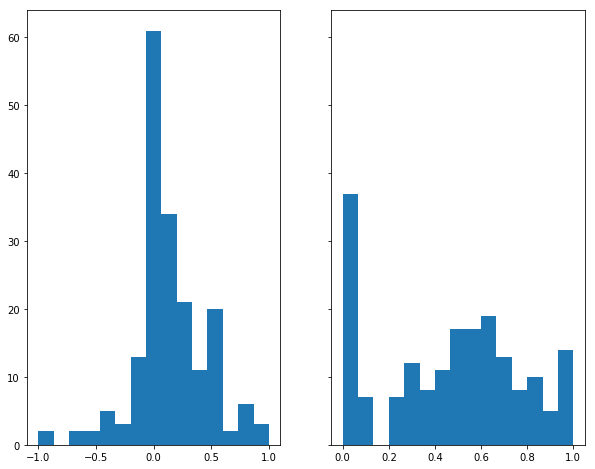

In [13]:
# PLOT RESULTS (TextBlob) - HISTOGRAMS
x = df_comments['Polarity'].values
y = df_comments['Subjectivity'].values

# plt.rcParams['figure.figsize']=[12,10]
# plt.subplot(1,2,1)
# plt

f, ax = plt.subplots(1,2, figsize=(10,8), sharey=True)
ax[0].hist(x, bins=15)
ax[1].hist(y, bins=15)
plt.show();

## IMPROVE SUBPLOTS

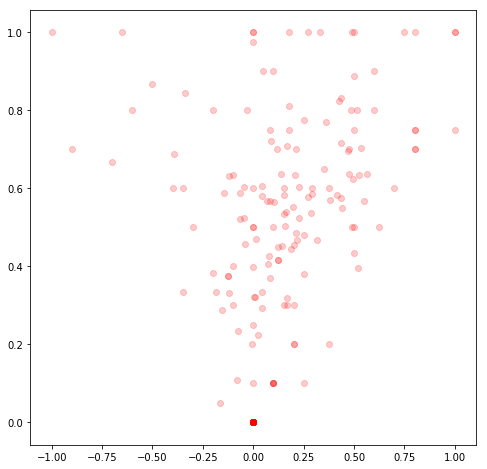

In [14]:
# PLOT RESULTS (TextBlob) - SCATTERPLOT, subjectivity vs. polarity
plt.figure(figsize=(8,8))
plt.scatter(x, y, marker='o', color = 'red', alpha=0.2)
plt.show();

# 2. Set up, run webscraping pipeline

Scrape, make csvs, and run NLP for most popular comics

### 2.1 Scrape the most popular comics

In [9]:
# GET A LIST OF THE MOST POPULAR SERIES
url = "https://readcomiconline.to/ComicList/MostPopular"
# driver = webdriver.Opera(executable_path='webdriver/operadriver_mac64/operadriver')

popular_series = get_issues(url)
popular_series = [series for series in popular_series if "?" not in series]
print(popular_series)

AttributeError: 'NoneType' object has no attribute 'find_elements_by_tag_name'

In [12]:
# MOST RECENT POPULAR_SERIES
popular_series = ['https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963', 'https://readcomiconline.to/Comic/Ultimate-Spider-Man-2000', 'https://readcomiconline.to/Comic/Saga', 'https://readcomiconline.to/Comic/The-Flash-2016', 'https://readcomiconline.to/Comic/Invincible', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Five', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-I', 'https://readcomiconline.to/Comic/Darth-Vader-2017', 'https://readcomiconline.to/Comic/Detective-Comics-2016', 'https://readcomiconline.to/Comic/W-i-t-c-h', 'https://readcomiconline.to/Comic/Rick-and-Morty', 'https://readcomiconline.to/Comic/Uncanny-X-Men-1963', 'https://readcomiconline.to/Comic/Sonic-The-Hedgehog', 'https://readcomiconline.to/Comic/Fables', 'https://readcomiconline.to/Comic/Red-Hood-and-the-Outlaws-2016', 'https://readcomiconline.to/Comic/Nightwing-2016', 'https://readcomiconline.to/Comic/Superman-2016', 'https://readcomiconline.to/Comic/Teen-Titans-2016', 'https://readcomiconline.to/Comic/Crossed-Badlands', 'https://readcomiconline.to/Comic/Justice-League', 'https://readcomiconline.to/Comic/Justice-League-2016', 'https://readcomiconline.to/Comic/Spawn', 'https://readcomiconline.to/Comic/Spider-Man-Deadpool', 'https://readcomiconline.to/Comic/The-Amazing-Spider-Man-2015', 'https://readcomiconline.to/Comic/Action-Comics-2016', 'https://readcomiconline.to/Comic/Old-Man-Logan-2016', 'https://readcomiconline.to/Comic/Titans-2016', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Two', 'https://readcomiconline.to/Comic/Preacher', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Three', 'https://readcomiconline.to/Comic/The-Boys', 'https://readcomiconline.to/Comic/Injustice-Gods-Among-Us-Year-Four', 'https://readcomiconline.to/Comic/Batman-1940', 'https://readcomiconline.to/Comic/Dark-Nights-Metal', 'https://readcomiconline.to/Comic/Mighty-Morphin-Power-Rangers', 'https://readcomiconline.to/Comic/Star-Wars-2015', 'https://readcomiconline.to/Comic/Injustice-Ground-Zero', 'https://readcomiconline.to/Comic/The-Sandman-1989', 'https://readcomiconline.to/Comic/Wonder-Woman-2016', 'https://readcomiconline.to/Comic/Doomsday-Clock', 'https://readcomiconline.to/Comic/Deadpool-2016', 'https://readcomiconline.to/Comic/Batman-2011', 'https://readcomiconline.to/Comic/The-Amazing-Spider-Man-2018', 'https://readcomiconline.to/Comic/Super-Sons', 'https://readcomiconline.to/Comic/Hal-Jordan-And-The-Green-Lantern-Corps', 'https://readcomiconline.to/Comic/Spider-Man-2016', 'https://readcomiconline.to/Comic/Darth-Vader']
current_series = ['https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963']

In [34]:
# LOAD A CSV FILE TO A DF (IF NEEDED)
csv_file_path = "comic_comments/comic_comments.csv"
loaded_df = pd.read_csv(csv_file_path, index_col='Unnamed: 0', encoding = "ISO-8859-1")
len(loaded_df)

3485

In [24]:
# SCRAPE ALL ISSUES FOR EVERY SERIES IN popular_series - takes in a loaded_df
# df = harvest(popular_series, df=loaded_df)

# SCRAPE INDIVIDUAL SERIES
df = harvest(current_series, df=loaded_df)

df loaded. df length: 3425
Scrape_series initaiated for https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963
df loaded. df length: 3425
Get Issues: total issues found: 705
Scrape_series: 705 issues found for https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963
The-Amazing-Spider-Man-1963/Issue-801 already scraped.
The-Amazing-Spider-Man-1963/Issue-800 already scraped.
The-Amazing-Spider-Man-1963/Issue-799 already scraped.
The-Amazing-Spider-Man-1963/Issue-798 already scraped.
The-Amazing-Spider-Man-1963/Issue-797 already scraped.
The-Amazing-Spider-Man-1963/Issue-796 already scraped.
The-Amazing-Spider-Man-1963/Issue-795 already scraped.
The-Amazing-Spider-Man-1963/Issue-794 already scraped.
The-Amazing-Spider-Man-1963/Issue-793 already scraped.
The-Amazing-Spider-Man-1963/Issue-792 already scraped.
The-Amazing-Spider-Man-1963/Issue-791 already scraped.
The-Amazing-Spider-Man-1963/Issue-790 already scraped.
The-Amazing-Spider-Man-1963/Issue-789 already scraped.
The-Amaz

Num iframes:  2
[]
Total issues scraped: 1
The-Amazing-Spider-Man-1963/Issue-552 already scraped.
The-Amazing-Spider-Man-1963/Issue-551 already scraped.
The-Amazing-Spider-Man-1963/Issue-550 already scraped.
The-Amazing-Spider-Man-1963/Issue-549 already scraped.
The-Amazing-Spider-Man-1963/Issue-548 already scraped.
The-Amazing-Spider-Man-1963/Issue-547 already scraped.
The-Amazing-Spider-Man-1963/Issue-546 already scraped.
The-Amazing-Spider-Man-1963/Issue-545 already scraped.
The-Amazing-Spider-Man-1963/Issue-544 already scraped.
The-Amazing-Spider-Man-1963/Issue-543 already scraped.
The-Amazing-Spider-Man-1963/Issue-542 already scraped.
The-Amazing-Spider-Man-1963/Issue-541 already scraped.
The-Amazing-Spider-Man-1963/Issue-540 already scraped.
The-Amazing-Spider-Man-1963/Issue-539 already scraped.
The-Amazing-Spider-Man-1963/Issue-538 already scraped.
The-Amazing-Spider-Man-1963/Issue-537 already scraped.
The-Amazing-Spider-Man-1963/Issue-536 already scraped.
The-Amazing-Spider-Man

Num iframes:  2
[]
Total issues scraped: 6
The-Amazing-Spider-Man-1963/Issue-357 already scraped.
Now scraping: https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-356
Num iframes:  2
[]
Total issues scraped: 7
The-Amazing-Spider-Man-1963/Issue-355 already scraped.
The-Amazing-Spider-Man-1963/Issue-354 already scraped.
Now scraping: https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-353
Num iframes:  2
[]
Total issues scraped: 8
The-Amazing-Spider-Man-1963/Issue-352 already scraped.
The-Amazing-Spider-Man-1963/Issue-351 already scraped.
The-Amazing-Spider-Man-1963/Issue-350 already scraped.
The-Amazing-Spider-Man-1963/Issue-349 already scraped.
The-Amazing-Spider-Man-1963/Issue-348 already scraped.
The-Amazing-Spider-Man-1963/Issue-347 already scraped.
The-Amazing-Spider-Man-1963/Issue-346 already scraped.
The-Amazing-Spider-Man-1963/Issue-345 already scraped.
The-Amazing-Spider-Man-1963/Issue-344 already scraped.
The-Amazing-Spider-Man-1963/Issue-343 alr

Num iframes:  2
[{'editableUntil': '2017-11-20T00:32:07', 'dislikes': 0, 'numReports': 0, 'likes': 7, 'message': "<p>NO<br>MORE<br>ORIGIN!<br>IT'S BEEN OVERDONE!<br>GOD!!!</p>", 'id': '3613105895', 'createdAt': '2017-11-13T00:32:07', 'author': {'username': 'asielhetsberger', 'about': 'I like stuff.', 'name': 'Avalanche', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-10-27T18:10:13', 'profileUrl': 'https://disqus.com/by/asielhetsberger/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '227996017', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/asielhetsberger.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/22799/6017/avatar32.jpg?1498154770'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/asielhetsberger.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/22799/6017/avatar92.jpg?1498154770', 'large': {'permalink': 'https://disqus.com/a

Num iframes:  2
[{'editableUntil': '2017-02-14T03:52:43', 'dislikes': 0, 'numReports': 0, 'likes': 12, 'message': "<p>Peter's outfit that he was wearing at Harry and Liz's house was ridiculous! I was laughing so hard when I saw it. LMAO!</p>", 'id': '3141273099', 'createdAt': '2017-02-07T03:52:43', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/208

Num iframes:  2
[{'editableUntil': '2017-07-26T21:25:41', 'dislikes': 1, 'numReports': 0, 'likes': 4, 'message': "<p>I don't get how anyone could prefer Felicia with Peter over MJ... Felicia didn't care about Peter, she only cares about Spider-Man.</p>", 'id': '3425409106', 'createdAt': '2017-07-19T21:25:41', 'author': {'username': 'broegan', 'about': '', 'name': '✨broegan✨', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-05-10T18:55:57', 'profileUrl': 'https://disqus.com/by/broegan/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '251484096', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/broegan.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/25148/4096/avatar32.jpg?1542231689'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/broegan.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/25148/4096/avatar92.jpg?1542231689', 'large': {'

Num iframes:  2
[{'editableUntil': '2016-07-26T20:22:40', 'dislikes': 0, 'numReports': 0, 'likes': 3, 'message': '<p>(read The Spectacular Spider-Man Issue#76)... getting a headache, if you actualy read this comic complete i would like to know how to read this chronologicaly.</p>', 'id': '2792034452', 'createdAt': '2016-07-19T20:22:40', 'author': {'username': 'the_thyphoon', 'about': 'Soldier', 'name': 'the_thyphoon', 'disable3rdPartyTrackers': True, 'isPowerContributor': False, 'joinedAt': '2015-04-18T07:00:36', 'profileUrl': 'https://disqus.com/by/the_thyphoon/', 'url': '', 'location': 'Stratis', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '154089274', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/the_thyphoon.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/15408/9274/avatar32.jpg?1465167785'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/the_thyphoon.jpg', 'cache': 'https://c.disquscdn.co

Num iframes:  2
[{'editableUntil': '2018-02-12T22:43:49', 'dislikes': 0, 'numReports': 0, 'likes': 3, 'message': "<p>I'll never understand why Roger Stern didn't like using any of Spidey's classic villains, except the Vulture. I mean Juggernaunt was amazing and Hyde was fun and exciting, but did he really believe watching Spider-Man fight Stilt-Man would be more fun than the other villains.</p><p>(My personal favorite is Mysterio and I wish he would show up more often)</p>", 'id': '3744374284', 'createdAt': '2018-02-05T22:43:49', 'author': {'username': 'ronald_corbin', 'about': '', 'name': 'Silver Agent', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-03-05T22:18:48', 'profileUrl': 'https://disqus.com/by/ronald_corbin/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '244487028', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/ronald_corbin.jpg', 'cache': 'https://c

Num iframes:  2
[{'editableUntil': '2018-02-14T19:14:14', 'dislikes': 0, 'numReports': 0, 'likes': 1, 'message': '<p>Well, that was dumb of him, of course he can close his eye behind his mask. That goes without saying.</p>', 'id': '3747444286', 'createdAt': '2018-02-07T19:14:14', 'author': {'username': 'Jason_Fallen_Son', 'about': '', 'name': 'Jason_Fallen_Son', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-11-26T15:48:10', 'profileUrl': 'https://disqus.com/by/Jason_Fallen_Son/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '184422933', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar32.jpg?1502146656'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar92.jpg?1502146656',

Num iframes:  2
[{'editableUntil': '2017-09-08T01:33:18', 'dislikes': 0, 'numReports': 0, 'likes': 2, 'message': "<p>............Okay, so all those nights interrupted by Pincus and his singing practice are officially forgiven via the food clause. That's the move to win anyone.</p>", 'id': '3496793439', 'createdAt': '2017-09-01T01:33:18', 'author': {'username': 'colin_o_donoghue', 'about': '', 'name': "Colin O'Donoghue", 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-07-17T10:13:45', 'profileUrl': 'https://disqus.com/by/colin_o_donoghue/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '259209207', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/colin_o_donoghue.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/25920/9207/avatar32.jpg?1558284841'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/colin_o_donoghue.jpg', 'cache': 'https://c.disq

Num iframes:  2
[{'editableUntil': '2017-12-16T18:42:26', 'dislikes': 0, 'numReports': 0, 'likes': 3, 'message': '<p>I knew you weren’t a total prick, Ned.</p>', 'id': '3654521342', 'createdAt': '2017-12-09T18:42:26', 'author': {'username': 'amanze_ihedioha', 'about': 'It’s Coming Together.', 'name': 'Insane Disciple', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-10-29T01:34:25', 'profileUrl': 'https://disqus.com/by/amanze_ihedioha/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '269554004', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/amanze_ihedioha.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/26955/4004/avatar32.jpg?1558554111'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/amanze_ihedioha.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/26955/4004/avatar92.jpg?1558554111', 'large': {'permalink': 'https://disqus.com/ap

Num iframes:  2
[{'editableUntil': '2018-01-29T19:45:27', 'dislikes': 0, 'numReports': 0, 'likes': 4, 'message': '<p>Did Juggs just walk casually in the ocean? Damn son.</p>', 'id': '3720864089', 'createdAt': '2018-01-22T19:45:27', 'author': {'username': 'Jason_Fallen_Son', 'about': '', 'name': 'Jason_Fallen_Son', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-11-26T15:48:10', 'profileUrl': 'https://disqus.com/by/Jason_Fallen_Son/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '184422933', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar32.jpg?1502146656'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar92.jpg?1502146656', 'large': {'permalink': 'https://disqus.com/api/u

Num iframes:  2
[{'editableUntil': '2017-02-08T02:43:34', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': '<p>This issue started out good between Spider-Man and Black Cat but it sure went down hill quickly. I feel bad for both Peter and Felicia.</p>', 'id': '3131415838', 'createdAt': '2017-02-01T02:43:34', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/up

Num iframes:  2
[{'editableUntil': '2017-02-08T02:04:56', 'dislikes': 0, 'numReports': 0, 'likes': 11, 'message': "<p>So Felicia tricked Peter into thinking she was crazy so she wouldn't have to go to prison and instead she went to a mental hospital? That's genius! It's also a little funny. Lol!</p>", 'id': '3131368488', 'createdAt': '2017-02-01T02:04:56', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO

Num iframes:  2
[{'editableUntil': '2017-11-07T14:45:30', 'dislikes': 0, 'numReports': 0, 'likes': 5, 'message': '<p>I\'d like to have a list of all the times Peter thought "Spider-Sense\'s tingling... ah, well! Must be because of me being tired/ injured/ caught up in my thoughts/ being stressed...." and always being wrong about it.</p>', 'id': '3593314400', 'createdAt': '2017-10-31T13:45:30', 'author': {'username': 'benjaminve', 'about': '', 'name': 'Benjamin Ve', 'disable3rdPartyTrackers': True, 'isPowerContributor': False, 'joinedAt': '2017-03-23T08:45:43', 'profileUrl': 'https://disqus.com/by/benjaminve/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '246461138', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/benjaminve.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/24646/1138/avatar32.jpg?1554651019'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/benjaminve.jpg

Num iframes:  2
[{'editableUntil': '2017-08-29T12:48:46', 'dislikes': 0, 'numReports': 0, 'likes': 5, 'message': "<p>Ahh, now the Vulture has at least stayed true to villainy. No revenge quests, or mad world domination plots; just simple jewel heists, bank robberies, the classics.</p><p>Y'know, you'd think with the amount of times Pete's run into villains in his personal life he'd learn to put on a poker face.</p>", 'id': '3480999389', 'createdAt': '2017-08-22T12:48:46', 'author': {'username': 'colin_o_donoghue', 'about': '', 'name': "Colin O'Donoghue", 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-07-17T10:13:45', 'profileUrl': 'https://disqus.com/by/colin_o_donoghue/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '259209207', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/colin_o_donoghue.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/25920/9207/avatar3

Num iframes:  2
[{'editableUntil': '2018-01-18T19:38:54', 'dislikes': 0, 'numReports': 0, 'likes': 2, 'message': '<p>Page 2: Spider-Man dabbing like a pro.</p>', 'id': '3703120709', 'createdAt': '2018-01-11T19:38:54', 'author': {'username': 'Jason_Fallen_Son', 'about': '', 'name': 'Jason_Fallen_Son', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-11-26T15:48:10', 'profileUrl': 'https://disqus.com/by/Jason_Fallen_Son/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '184422933', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar32.jpg?1502146656'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar92.jpg?1502146656', 'large': {'permalink': 'https://disqus.com/api/users/avatars/J

Num iframes:  2
[{'editableUntil': '2017-02-09T16:59:38', 'dislikes': 0, 'numReports': 0, 'likes': 4, 'message': "<p>Peter, don't knock the Phone Booth, it's a classic. All you need is to Web it up first</p>", 'id': '3134220814', 'createdAt': '2017-02-02T16:59:38', 'author': {'username': 'spiritburst', 'about': '', 'name': 'SpiritBurst', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-07-25T16:00:37', 'profileUrl': 'https://disqus.com/by/spiritburst/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '166801378', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/16680/1378/avatar32.jpg?1438210775'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/16680/1378/avatar92.jpg?1438210775', 'large': {'permalink': 'https://disqus

Num iframes:  2
[{'editableUntil': '2017-08-28T01:19:49', 'dislikes': 0, 'numReports': 0, 'likes': 5, 'message': "<p>So Daredevil just happens to be Peter's attorney in this case, huh?</p>", 'id': '3478653078', 'createdAt': '2017-08-21T01:19:49', 'author': {'username': 'asielhetsberger', 'about': 'I like stuff.', 'name': 'Avalanche', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-10-27T18:10:13', 'profileUrl': 'https://disqus.com/by/asielhetsberger/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '227996017', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/asielhetsberger.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/22799/6017/avatar32.jpg?1498154770'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/asielhetsberger.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/22799/6017/avatar92.jpg?1498154770', 'large': {'permalink': 'https:/

Num iframes:  2
[{'editableUntil': '2017-08-28T03:56:12', 'dislikes': 0, 'numReports': 0, 'likes': 4, 'message': "<p>This might just be one of the stupidest comics I've ever read in my life.</p>", 'id': '3478822400', 'createdAt': '2017-08-21T03:56:12', 'author': {'username': 'maskedguy', 'about': '', 'name': 'Masked Guy', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-12-03T21:14:43', 'profileUrl': 'https://disqus.com/by/maskedguy/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '233150593', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/maskedguy.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/23315/593/avatar32.jpg?1506537854'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/maskedguy.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/23315/593/avatar92.jpg?1506537854', 'large': {'permalink': 'https://disqus.com/api/users/avatars/m

Num iframes:  2
[{'editableUntil': '2017-04-25T20:47:13', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': '<p>Rifkin, the Number One rule of a twist ending is YOU NEVER SPOIL IT FOR OTHER PEOPLE! Peter has every right to hate you after you pull a move like that.</p>', 'id': '3262062821', 'createdAt': '2017-04-18T20:47:13', 'author': {'username': 'anime_planeswalker', 'about': 'Fan of anime and MtG, not necessarily in that order.', 'name': 'The Anime Planeswalker', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-03-16T00:25:36', 'profileUrl': 'https://disqus.com/by/anime_planeswalker/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '245648892', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/anime_planeswalker.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/24564/8892/avatar32.jpg?1489624174'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users

Num iframes:  2
[{'editableUntil': '2018-01-02T19:08:31', 'dislikes': 0, 'numReports': 0, 'likes': 4, 'message': "<p>Knees weak, arms feel like spaghetti. Mom's spaghetti.</p>", 'id': '3679204036', 'createdAt': '2017-12-26T19:08:31', 'author': {'username': 'Jason_Fallen_Son', 'about': '', 'name': 'Jason_Fallen_Son', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-11-26T15:48:10', 'profileUrl': 'https://disqus.com/by/Jason_Fallen_Son/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '184422933', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar32.jpg?1502146656'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar92.jpg?1502146656', 'large': {'permalink': 'https://disqus.com/api

Num iframes:  2
[{'editableUntil': '2017-04-25T17:42:54', 'dislikes': 1, 'numReports': 0, 'likes': 6, 'message': '<p>Sandman can\'t swim huh? Even more evidence that the nuclear test story is a cover and in reality he ate the Sand-Sand Devil Fruit.</p><p>Also, Namor really needs to learn that humans keep these things called "secrets" where they don\'t tell other people things, and so the vast population of the planet might not be aware of the fact that your nemesis is hiding out in a hotel. He acts like such a royal brat sometimes.</p>', 'id': '3261761265', 'createdAt': '2017-04-18T17:42:54', 'author': {'username': 'anime_planeswalker', 'about': 'Fan of anime and MtG, not necessarily in that order.', 'name': 'The Anime Planeswalker', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-03-16T00:25:36', 'profileUrl': 'https://disqus.com/by/anime_planeswalker/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': F

Num iframes:  2
[{'editableUntil': '2017-04-27T03:12:09', 'dislikes': 0, 'numReports': 0, 'likes': 5, 'message': '<p>"A date with DW isn\'t the most exciting thing in the world" Peter\'s a savage.</p>', 'id': '3264273483', 'createdAt': '2017-04-20T03:12:09', 'author': {'username': 'disqus_FvsOpfbItU', 'about': '', 'name': 'Andrés Mèndez', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-04-18T02:33:14', 'profileUrl': 'https://disqus.com/by/disqus_FvsOpfbItU/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '249171397', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_FvsOpfbItU.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/24917/1397/avatar32.jpg?1534870676'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_FvsOpfbItU.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/24917/1397/avatar92.jpg?1534870676', 'large': {'permalin

Num iframes:  2
[{'editableUntil': '2017-01-30T03:14:48', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': '<p>"Where is my Super Suit!?"</p>', 'id': '3114032742', 'createdAt': '2017-01-23T03:14:48', 'author': {'username': 'spiritburst', 'about': '', 'name': 'SpiritBurst', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-07-25T16:00:37', 'profileUrl': 'https://disqus.com/by/spiritburst/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '166801378', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/16680/1378/avatar32.jpg?1438210775'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/16680/1378/avatar92.jpg?1438210775', 'large': {'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c

Num iframes:  2
[{'editableUntil': '2017-08-14T20:17:39', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': '<p>First MAdame Web Appearence</p>', 'id': '3456562337', 'createdAt': '2017-08-07T20:17:39', 'author': {'username': 'BDubsMonkey', 'about': 'Im cool', 'name': 'BDubsMonkey', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2014-07-03T22:53:23', 'profileUrl': 'https://disqus.com/by/BDubsMonkey/', 'url': '', 'location': 'Behind you.', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '113069534', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar32.jpg?1500413985'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar92.jpg?1500413985', 'large': {'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', '

Num iframes:  2
[{'editableUntil': '2018-01-01T20:29:01', 'dislikes': 1, 'numReports': 0, 'likes': 3, 'message': '<p>Putting an ad on the cover is the worst idea ever IMO.</p>', 'id': '3678184059', 'createdAt': '2017-12-25T20:29:01', 'author': {'username': 'Jason_Fallen_Son', 'about': '', 'name': 'Jason_Fallen_Son', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-11-26T15:48:10', 'profileUrl': 'https://disqus.com/by/Jason_Fallen_Son/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '184422933', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar32.jpg?1502146656'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar92.jpg?1502146656', 'large': {'permalink': 'https://disqus.com/api

Num iframes:  2
[{'editableUntil': '2017-12-16T19:55:47', 'dislikes': 0, 'numReports': 0, 'likes': 1, 'message': '<p>Well regarded? With that costume?</p>', 'id': '3654665204', 'createdAt': '2017-12-09T19:55:47', 'author': {'username': 'amanze_ihedioha', 'about': 'It’s Coming Together.', 'name': 'Insane Disciple', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-10-29T01:34:25', 'profileUrl': 'https://disqus.com/by/amanze_ihedioha/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '269554004', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/amanze_ihedioha.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/26955/4004/avatar32.jpg?1558554111'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/amanze_ihedioha.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/26955/4004/avatar92.jpg?1558554111', 'large': {'permalink': 'https://disqus.com/api/use

Num iframes:  2
[{'editableUntil': '2017-08-14T18:28:53', 'dislikes': 0, 'numReports': 0, 'likes': 3, 'message': "<p>Jonah will find any way to pin anything on spider-man. Oh man I dropped a cookie, it's spider-mans fault. Someone is holding the restroom up, it's probably spider-man.</p>", 'id': '3456369696', 'createdAt': '2017-08-07T18:28:53', 'author': {'username': 'BDubsMonkey', 'about': 'Im cool', 'name': 'BDubsMonkey', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2014-07-03T22:53:23', 'profileUrl': 'https://disqus.com/by/BDubsMonkey/', 'url': '', 'location': 'Behind you.', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '113069534', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar32.jpg?1500413985'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disqu

Num iframes:  2
[{'editableUntil': '2017-02-05T04:14:23', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': "<p>Damn I knew Black Cat liked Spider-Man but I didn't know she was obsessed with him.</p>", 'id': '3125792215', 'createdAt': '2017-01-29T04:14:23', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar92.jpg?1558485643', 'la

Num iframes:  2
[{'editableUntil': '2017-07-31T23:47:29', 'dislikes': 1, 'numReports': 0, 'likes': 3, 'message': "<p>Poor Robbie...like the cliched Dark Knight quote, you either die a hero or live long enough to be the villain. All that pressure will get to you.</p><p>Ah yes...Black Cat's shrine....Boy, what a woman. I know she's basically just one of those purposely sexualized femme fatale characters that are meant as an excuse for the artists and readers alike to have some eye candy...but I really can't complain. xD</p><p>Kind of interesting, she's one of the first women in Pete's life that's less interested in his 'civilian' life than as the crusading wall-crawler. Most of his previous flames had wanted nothing to do with Spidey or were only interested in Pete for his intelligence. Black Cat is the opposite; she cares not a lick about any of his other life, only the Spider.</p><p>Course...we could probably rant about the psychology behind that, but then I'd have to go back to school

Num iframes:  2
[{'editableUntil': '2018-01-01T20:03:42', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': '<p>Dazzler: How can I repay you?<br>Peter: ( ͡° ͜ʖ ͡°)</p>', 'id': '3678163723', 'createdAt': '2017-12-25T20:03:42', 'author': {'username': 'Jason_Fallen_Son', 'about': '', 'name': 'Jason_Fallen_Son', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-11-26T15:48:10', 'profileUrl': 'https://disqus.com/by/Jason_Fallen_Son/', 'url': '', 'location': '', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '184422933', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar32.jpg?1502146656'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/Jason_Fallen_Son.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/18442/2933/avatar92.jpg?1502146656', 'large': {'permalink': 'https://disqus.com/api/us

Num iframes:  2
[{'editableUntil': '2017-02-04T03:00:05', 'dislikes': 0, 'numReports': 0, 'likes': 4, 'message': "<p>Well It's safe to say that April and MJ don't like each other. Lol!</p>", 'id': '3124274973', 'createdAt': '2017-01-28T03:00:05', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar92.jpg?1558485643', 'large': {'permalin

Num iframes:  2
[{'editableUntil': '2017-01-27T23:07:07', 'dislikes': 0, 'numReports': 0, 'likes': 12, 'message': '<p>Angry Spidey is low-key best Spidey.</p>', 'id': '3110448448', 'createdAt': '2017-01-20T23:07:07', 'author': {'username': 'spiritburst', 'about': '', 'name': 'SpiritBurst', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2015-07-25T16:00:37', 'profileUrl': 'https://disqus.com/by/spiritburst/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '166801378', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/16680/1378/avatar32.jpg?1438210775'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/16680/1378/avatar92.jpg?1438210775', 'large': {'permalink': 'https://disqus.com/api/users/avatars/spiritburst.jpg', 'cache':

Num iframes:  2
[{'editableUntil': '2017-07-27T21:09:54', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': "<p>Y'know, you kinda have to had it to Mysterio. He literally has no idea to expect Spider-Man. These were all defenses he had on standby just on the most whimsical off chance Spidey or some other superhero should decide to come snooping around.<br>Obviously, yeah, it's just a comic book enjoying all the conveniences, still....</p>", 'id': '3427398331', 'createdAt': '2017-07-20T21:09:54', 'author': {'username': 'colin_o_donoghue', 'about': '', 'name': "Colin O'Donoghue", 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-07-17T10:13:45', 'profileUrl': 'https://disqus.com/by/colin_o_donoghue/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '259209207', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/colin_o_donoghue.jpg', 'cache': 'https://c.disquscdn.com/up

Num iframes:  2
[{'editableUntil': '2017-04-24T06:42:13', 'dislikes': 0, 'numReports': 0, 'likes': 8, 'message': '<p>Anyone else notice that a good part of this issue is about dealing with your past?</p>', 'id': '3259529291', 'createdAt': '2017-04-17T06:42:13', 'author': {'username': 'anime_planeswalker', 'about': 'Fan of anime and MtG, not necessarily in that order.', 'name': 'The Anime Planeswalker', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-03-16T00:25:36', 'profileUrl': 'https://disqus.com/by/anime_planeswalker/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '245648892', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/anime_planeswalker.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/24564/8892/avatar32.jpg?1489624174'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/anime_planeswalker.jpg', 'cache': 'https://c.disquscdn.com/up

Num iframes:  2
[{'editableUntil': '2017-02-02T02:39:15', 'dislikes': 1, 'numReports': 0, 'likes': 9, 'message': '<p>Black Cat aka Felicia Hardy finally makes her appearance!</p>', 'id': '3120393710', 'createdAt': '2017-01-26T02:39:15', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar92.jpg?1558485643', 'large': {'permalink': 'https

Num iframes:  2
[{'editableUntil': '2017-08-13T04:57:47', 'dislikes': 0, 'numReports': 0, 'likes': 6, 'message': "<p>Jameson, i get your son died but don't blame that on spidey too.</p>", 'id': '3453852988', 'createdAt': '2017-08-06T04:57:47', 'author': {'username': 'BDubsMonkey', 'about': 'Im cool', 'name': 'BDubsMonkey', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2014-07-03T22:53:23', 'profileUrl': 'https://disqus.com/by/BDubsMonkey/', 'url': '', 'location': 'Behind you.', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '113069534', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar32.jpg?1500413985'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar92.jpg?1500413985', 'large': {'permalink': 'https://disqus.com/

Num iframes:  2
[{'editableUntil': '2017-08-11T22:04:51', 'dislikes': 0, 'numReports': 0, 'likes': 4, 'message': '<p>Low budget villian.</p>', 'id': '3452190139', 'createdAt': '2017-08-04T22:04:51', 'author': {'username': 'BDubsMonkey', 'about': 'Im cool', 'name': 'BDubsMonkey', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2014-07-03T22:53:23', 'profileUrl': 'https://disqus.com/by/BDubsMonkey/', 'url': '', 'location': 'Behind you.', 'isPrivate': True, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '113069534', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar32.jpg?1500413985'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/11306/9534/avatar92.jpg?1500413985', 'large': {'permalink': 'https://disqus.com/api/users/avatars/BDubsMonkey.jpg', 'cache': 

Num iframes:  2
[{'editableUntil': '2017-01-29T02:37:08', 'dislikes': 0, 'numReports': 0, 'likes': 5, 'message': '<p>Oh no! I have a bad feeling about the next issue.</p>', 'id': '3112213800', 'createdAt': '2017-01-22T02:37:08', 'author': {'username': 'disqus_bvaJgFELO7', 'about': '', 'name': 'Felicia Hardy (Black Cat)', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2016-05-20T01:09:25', 'profileUrl': 'https://disqus.com/by/disqus_bvaJgFELO7/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '208681915', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar32.jpg?1558485643'}, 'isCustom': True, 'permalink': 'https://disqus.com/api/users/avatars/disqus_bvaJgFELO7.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/20868/1915/avatar92.jpg?1558485643', 'large': {'permalink': 'https://disqu

Num iframes:  2
[{'editableUntil': '2017-04-20T14:52:39', 'dislikes': 0, 'numReports': 0, 'likes': 8, 'message': '<p>Kudos to the writers for an amazing plot twist. Came out of nowhere and yet it isn\'t one of those "pulled from the hat" plot twists that don\'t have any foreshadowing or logic too them.</p>', 'id': '3254363026', 'createdAt': '2017-04-13T14:52:39', 'author': {'username': 'anime_planeswalker', 'about': 'Fan of anime and MtG, not necessarily in that order.', 'name': 'The Anime Planeswalker', 'disable3rdPartyTrackers': False, 'isPowerContributor': False, 'joinedAt': '2017-03-16T00:25:36', 'profileUrl': 'https://disqus.com/by/anime_planeswalker/', 'url': '', 'location': '', 'isPrivate': False, 'signedUrl': '', 'isPrimary': True, 'isAnonymous': False, 'id': '245648892', 'avatar': {'small': {'permalink': 'https://disqus.com/api/users/avatars/anime_planeswalker.jpg', 'cache': 'https://c.disquscdn.com/uploads/users/24564/8892/avatar32.jpg?1489624174'}, 'isCustom': True, 'permali

Num iframes:  0
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-177 - total fails: 3
The-Amazing-Spider-Man-1963/Issue-176 already scraped.
The-Amazing-Spider-Man-1963/Issue-175 already scraped.
The-Amazing-Spider-Man-1963/Issue-174 already scraped.
Now scraping: https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-173
Num iframes:  0
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-173 - total fails: 4
The-Amazing-Spider-Man-1963/Issue-172 already scraped.
Now scraping: https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-171
Num iframes:  0
SCRAPING FAILED for https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-171 - total fails: 5
The-Amazing-Spider-Man-1963/Issue-170 already scraped.
The-Amazing-Spider-Man-1963/Issue-169 already scraped.
Now scraping: https://readcomiconline.to/Comic/The-Amazing-Spider-Man-1963/Issue-168
Num iframes:  0
SCRAPING FAILED for https:/

In [75]:
df_temp = pd.read_csv('comic_comments/comic_comments.csv')

In [76]:
len(df_temp)

8823

In [ ]:
df_comments = sentiment_analysis()

# 2. Comic Reviews EDA

## 2.1 Most common review words

USE PREVIOUS NLP SpaCy notebook TO DETERMINE MOST COMMON WORDS

GENERATE A TF-IDF OR WORD COUNT DF

VISUALIZE BY USING WORDCLOUD

https://www.youtube.com/watch?v=VraAbgAoYSk

In [18]:
temp = pd.read_csv('comic_comments/batman_2016_comments.csv')

In [ ]:
# PLOT SENTIMENTS